In [88]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
df = pd.read_csv(r'data\Airline_Delay_Cause.csv')
df.head(5)

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2025,7,YV,Mesa Airlines Inc.,BWI,"Baltimore, MD: Baltimore/Washington Internatio...",18.0,2.0,1.43,0.00,...,0.0,0.00,0.0,0.0,44.0,32.0,0.0,12.0,0.0,0.0
1,2025,7,YV,Mesa Airlines Inc.,CHS,"Charleston, SC: Charleston AFB/International",48.0,16.0,4.06,3.15,...,0.0,3.30,2.0,0.0,1282.0,331.0,438.0,259.0,0.0,254.0
2,2025,7,YV,Mesa Airlines Inc.,CLE,"Cleveland, OH: Cleveland-Hopkins International",65.0,10.0,3.53,1.00,...,0.0,2.43,2.0,0.0,735.0,151.0,172.0,139.0,0.0,273.0
3,2025,7,YV,Mesa Airlines Inc.,CLT,"Charlotte, NC: Charlotte Douglas International",134.0,31.0,13.19,2.43,...,0.0,4.74,8.0,0.0,2264.0,798.0,303.0,702.0,0.0,461.0
4,2025,7,YV,Mesa Airlines Inc.,CMH,"Columbus, OH: John Glenn Columbus International",61.0,12.0,6.44,0.28,...,0.0,1.69,0.0,0.0,630.0,211.0,17.0,123.0,0.0,279.0


In [ ]:
# Drop the single row with a missing target-related values 
df.dropna(subset=['arr_del15'], inplace=True)

# Filter out records with no arriving flights
df = df[df['arr_flights'] > 0].copy()

# Create the Target Variable: Delay Rate
# Target: The proportion of flights delayed >= 15 minutes
df['delay_rate'] = df['arr_del15'] / df['arr_flights']

print(f"Cleaned Data Shape: {df.shape}")

Cleaned Data Shape: (1890, 22)


# Feature Engineering


In [91]:
# --- 3. Feature Engineering: Target Encoding ---
# Target Encoding is used for high-cardinality categorical features (airport, carrier)
# to prevent creating hundreds of sparse columns via One-Hot Encoding.

def target_encode_feature(data, feature_col, target_col):
    """Calculates the mean of the target_col grouped by the feature_col."""
    # Calculate the mean delay rate for each group
    mapping = data.groupby(feature_col)[target_col].mean()
    # Apply the mean to create the encoded column
    encoded_col_name = f"{feature_col.split('_')[0]}_encoded"
    data[encoded_col_name] = data[feature_col].map(mapping)
    return data

# Encode Carrier Name
df = target_encode_feature(df, 'carrier_name', 'delay_rate')

# Encode Airport Name
df = target_encode_feature(df, 'airport_name', 'delay_rate')

# --- 4. Define Features and Target ---
# 'year' and 'month' are included as time-based features, though 'airport_encoded'
# and 'carrier_encoded' are the primary drivers. 'arr_flights' acts as a traffic volume feature.
FEATURES = ['year', 'month', 'arr_flights', 'carrier_encoded', 'airport_encoded']
TARGET = 'delay_rate'

X = df[FEATURES]
y = df[TARGET]

# Model Training and Evaluation (Random Forest Regressor)

In [93]:
# --- 5. Train-Test Split ---
# Use a standard 80/20 split for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train/Test Split: {X_train.shape[0]} training samples, {X_test.shape[0]} testing samples.")


# --- 6. Model Training ---
# Using Random Forest as a high-performance ensemble model
rf_model = RandomForestRegressor(
    n_estimators=100,             # Number of trees
    max_depth=10,                 # Max depth to prevent overfitting
    random_state=42,
    n_jobs=-1                     # Utilize all available cores
)

print("\n--- Training Model ---")
rf_model.fit(X_train, y_train)
print("Training Complete.")


# --- 7. Model Prediction and Evaluation ---
y_pred = rf_model.predict(X_test)

# Calculate key metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Performance Metrics ---")
print(f"Model Used: Random Forest Regressor")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared Score (R2): {r2:.4f}")

Train/Test Split: 1512 training samples, 378 testing samples.

--- Training Model ---
Training Complete.

--- Model Performance Metrics ---
Model Used: Random Forest Regressor
Mean Absolute Error (MAE): 0.0646
R-squared Score (R2): 0.4127


# Model Interpretability and Visualization


--- Feature Importance Breakdown ---
| Feature         | Importance   |
|:----------------|:-------------|
| airport_encoded | 0.410161     |
| arr_flights     | 0.341473     |
| carrier_encoded | 0.248366     |
| year            | 0            |
| month           | 0            |


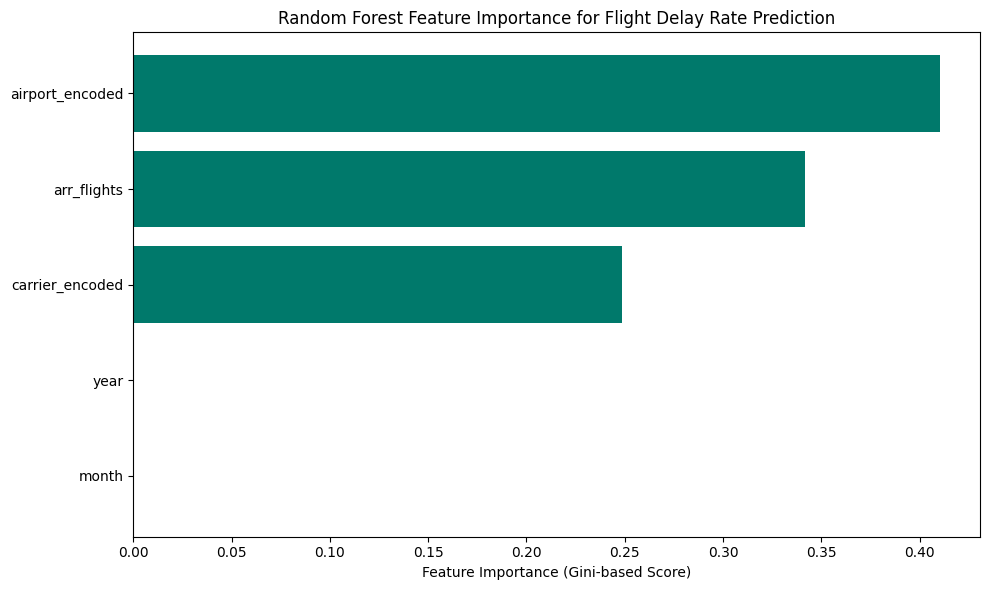


Final Results Log:
{'MAE': 0.0646, 'R2_Score': 0.4127, 'Features': {'airport_encoded': 0.4102, 'arr_flights': 0.3415, 'carrier_encoded': 0.2484, 'year': 0.0, 'month': 0.0}}


In [94]:
# --- 8. Model Interpretability: Feature Importance ---
feature_importance = pd.Series(
    rf_model.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False).reset_index()

feature_importance.columns = ['Feature', 'Importance']

print("\n--- Feature Importance Breakdown ---")
print(feature_importance.to_markdown(index=False, numalign="left", stralign="left"))


# --- 9. Visualization ---
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='#00796B')
plt.xlabel("Feature Importance (Gini-based Score)")
plt.title("Random Forest Feature Importance for Flight Delay Rate Prediction")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show() # Display the plot
# plt.savefig("feature_importance_plot.png") # Uncomment to save the plot

# Display the final results as a dictionary (optional for deployment/logging)
results = {
    "MAE": round(mae, 4),
    "R2_Score": round(r2, 4),
    "Features": feature_importance.set_index('Feature')['Importance'].round(4).to_dict()
}
print("\nFinal Results Log:")
print(results)